### In this Code, We got some help of different kernels (only a few code cells), we didn't follow a single kernel's idea but many kernels to make our own mix and ideas. On every piece of code that is taken from a public kernel, we stated the reference of the kernel to avoid plagiarism. 

# New York City Taxi Trip Duration Prediction

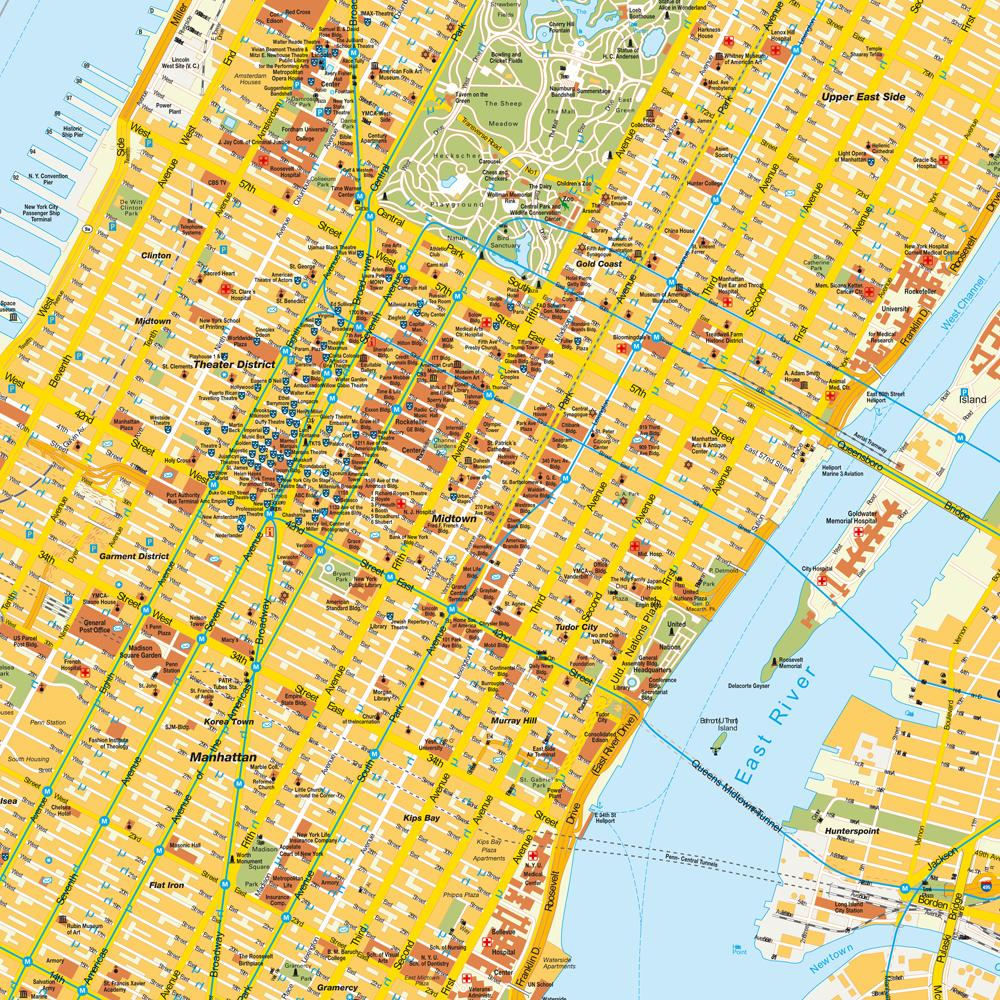

In [45]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import random
import seaborn as sns
from sklearn.manifold import TSNE
#/////////////////////////////////////////////////////////////////
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import lightgbm as lgb
from sklearn import linear_model
import math

In [46]:
train=pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [47]:
print(train.shape)
print(test.shape)

(1458644, 11)
(625134, 9)


# Detecting Outliers and remove them by calculating the percentile of the data
## Reference of the next cell : 
### https://www.kaggle.com/selfishgene/yellow-cabs-tell-the-story-of-new-york-city

In [48]:
allLat  = np.array(list(train['pickup_latitude'])  + list(train['dropoff_latitude']))
allLong = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(train['trip_duration'], 0.4), np.percentile(train['trip_duration'], 99.7)]

train = train[(train['pickup_latitude']   >= latLimits[0] ) & (train['pickup_latitude']   <= latLimits[1]) ]
train = train[(train['dropoff_latitude']  >= latLimits[0] ) & (train['dropoff_latitude']  <= latLimits[1]) ]
train = train[(train['pickup_longitude']  >= longLimits[0]) & (train['pickup_longitude']  <= longLimits[1])]
train = train[(train['dropoff_longitude'] >= longLimits[0]) & (train['dropoff_longitude'] <= longLimits[1])]
train = train[(train['trip_duration']     >= durLimits[0] ) & (train['trip_duration']     <= durLimits[1]) ]

In [49]:
print(train.shape)
print(test.shape)

(1420058, 11)
(625134, 9)


In [50]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# PickUp datetime datatype change to Pandas Datetime format 

In [51]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

# Remove the dropoff_date time since it's related to the target value and can't train using it

In [52]:
train.drop('dropoff_datetime',axis=1,inplace=True)

In [53]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [54]:
train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

# Adding and Dropping Features

### If the id is unique for each record then it's useless

In [55]:
if train.id.nunique()==train.shape[0]:
    train.drop('id',axis=1,inplace=True)
    #test.drop('id',axis=1,inplace=True) # will not remove it for now to use the id in the predictions
    print("dropped")
else:
    print("Not dropped")

dropped


### Extract time attributes for the general data type Datetime like : month, day , hour, minute, day of the week

In [56]:
train['pick_upMonth']=train.pickup_datetime.dt.month
train['pick_upDay']=train.pickup_datetime.dt.day
train['pick_upHour']=train.pickup_datetime.dt.hour
train['pick_upMinute']=train.pickup_datetime.dt.minute
train['dayOfWeek']= pd.to_datetime(train['pickup_datetime']).dt.weekday

test['pick_upMonth']=test.pickup_datetime.dt.month
test['pick_upDay']=test.pickup_datetime.dt.day
test['pick_upHour']=test.pickup_datetime.dt.hour
test['pick_upMinute']=test.pickup_datetime.dt.minute
test['dayOfWeek']= pd.to_datetime(test['pickup_datetime']).dt.weekday

In [57]:
#Reference : https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [58]:
train.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_upMonth,pick_upDay,pick_upHour,pick_upMinute,dayOfWeek
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,17,24,0
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,0,43,6
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,11,35,1
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,19,32,2
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,13,30,5


### Then Drop the pickup_datetime after getting all the information we need from it

In [59]:
train.drop('pickup_datetime',axis=1,inplace=True)
test.drop('pickup_datetime',axis=1,inplace=True)

### Different ways to measure distance and adding a feature to calculate the distance between pickup and dropoff

Reference of the next cell : https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

In [60]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#### Reference of manhattenDistance : StackOverFlow

In [61]:
def manhattenDistance(pickLongitude, pickLatitude,dropLongitude,dropLatitude):
    return (np.abs(pickLongitude-dropLongitude)+np.abs(pickLatitude-dropLatitude))
    

### Euclidean Distance

#### Creating new Attribute Columns

In [63]:
train['manhattenDistance']=manhattenDistance(train['pickup_longitude'],train['pickup_latitude'],train['dropoff_longitude'],train['dropoff_latitude'])
test['manhattenDistance']=manhattenDistance(test['pickup_longitude'],test['pickup_latitude'],test['dropoff_longitude'],test['dropoff_latitude'])

In [64]:
train['haversine']=haversine_array(train['pickup_longitude'],train['pickup_latitude'],train['dropoff_longitude'],train['dropoff_latitude'])
test['haversine']=haversine_array(test['pickup_longitude'],test['pickup_latitude'],test['dropoff_longitude'],test['dropoff_latitude'])

In [65]:
test.dtypes

id                     object
vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
pick_upMonth            int64
pick_upDay              int64
pick_upHour             int64
pick_upMinute           int64
dayOfWeek               int64
manhattenDistance     float64
haversine             float64
dtype: object

train['euclidean']=EuclideanDistance(train['pickup_longitude'],train['pickup_latitude'],train['dropoff_longitude'],train['dropoff_latitude'])
test['euclidean']=EuclideanDistance(test['pickup_longitude'],test['pickup_latitude'],test['dropoff_longitude'],test['dropoff_latitude'])

In [67]:
train.drop('pickup_longitude',axis=1,inplace=True)
train.drop('pickup_latitude',axis=1,inplace=True)
train.drop('dropoff_longitude',axis=1,inplace=True)
train.drop('dropoff_latitude',axis=1,inplace=True)

test.drop('pickup_longitude',axis=1,inplace=True)
test.drop('pickup_latitude',axis=1,inplace=True)
test.drop('dropoff_longitude',axis=1,inplace=True)
test.drop('dropoff_latitude',axis=1,inplace=True)

### We can't train data with strings values so we encode them 

In [68]:
train.loc[(train.store_and_fwd_flag =='N'),"store_and_fwd_flag"] = 0
train.loc[(train.store_and_fwd_flag =='Y'),"store_and_fwd_flag"] = 1

test.loc[(test.store_and_fwd_flag =='N'),"store_and_fwd_flag"] = 0
test.loc[(test.store_and_fwd_flag =='Y'),"store_and_fwd_flag"] = 1


### Changing the data type of the attribute to int because it's stored as an 'Object'

In [69]:
train['store_and_fwd_flag'] = train.store_and_fwd_flag.astype('int8')
test['store_and_fwd_flag'] = test.store_and_fwd_flag.astype('int8')

In [70]:
train.drop('pick_upMonth',axis=1,inplace=True)
test.drop('pick_upMonth',axis=1,inplace=True)

In [71]:
train.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pick_upDay,pick_upHour,pick_upMinute,dayOfWeek,manhattenDistance,haversine,euclidean
0,2,1,0,455,14,17,24,0,0.019859,1.949977,0.017680
1,1,1,0,663,12,0,43,6,0.026478,2.132178,0.020456
2,2,1,0,2124,19,11,35,1,0.080158,3.359039,0.059934
3,2,1,0,429,6,19,32,2,0.015480,0.475519,0.013438
4,2,1,0,435,26,13,30,5,0.010818,0.328461,0.010690


In [72]:
test.head()

,id,vendor_id,passenger_count,store_and_fwd_flag,pick_upDay,pick_upHour,pick_upMinute,dayOfWeek,manhattenDistance,haversine,euclidean
0,id3004672,1,1,0,30,23,59,3,0.026695,0.789473,0.024735
1,id3505355,1,1,0,30,23,59,3,0.028984,0.899670,0.024979
2,id1217141,1,1,0,30,23,59,3,0.019337,1.277991,0.013861
3,id2150126,2,1,0,30,23,59,3,0.071789,3.607318,0.051363
4,id1598245,1,1,0,30,23,59,3,0.014290,0.983047,0.010343


# Groupby And Merge

### We got the idea from a kernel found in an another Competition (Classification Problem) But we found that it ### increased the accuracy of the model so we applied it on this competition
Reference : https://www.kaggle.com/tetyanayatsenko/prepare-data-form-features-find-their-importance

### Here we use the groupby() function to group the records with the same "vendor_id" ,'pick_upDay' and. 'pick_upHour' and calculate the variance of the manhattenDistance of each group

In [73]:
print("Beginning")
all_features = list(set(['vendor_id','pick_upDay','pick_upHour'] +['manhattenDistance']))
print("Beginning")
# Name of new feature
new_feature = '{}_{}_{}'.format('_'.join(['vendor_id','pick_upDay','pick_upHour']), 'var', 'manhattenDistance')
print("Beginning")
 # Perform the groupby on column names in 'groupby' field then calculate variance 
gp_train = train[all_features].groupby(['vendor_id','pick_upDay','pick_upHour'])['manhattenDistance'].agg('var').reset_index().rename(index=str, columns={'manhattenDistance': new_feature}).astype('float32')
gp_test = test[all_features].groupby(['vendor_id','pick_upDay','pick_upHour'])['manhattenDistance'].agg('var').reset_index().rename(index=str, columns={'manhattenDistance': new_feature}).astype('float32')
print("Beginning")
 # Merge back to X_train
train = train.merge(gp_train, on=['vendor_id','pick_upDay','pick_upHour'], how='left')
test = test.merge(gp_test, on=['vendor_id','pick_upDay','pick_upHour'], how='left')
print("Ending")

Beginning
Beginning
Beginning
Beginning
Ending


### the same thing but by calculating the variance of the haversine attribute 

In [74]:
print("Beginning")
all_features = list(set(['vendor_id','pick_upDay','pick_upHour'] +['haversine']))
print("Beginning")
# Name of new feature
new_feature = '{}_{}_{}'.format('_'.join(['vendor_id','pick_upDay','pick_upHour']), 'var', 'haversine')
print("Beginning")
 # Perform the groupby on column names in 'groupby' field then calculate variance for column in 'select' field
gp_train = train[all_features].groupby(['vendor_id','pick_upDay','pick_upHour'])['haversine'].agg('var').reset_index().rename(index=str, columns={'haversine': new_feature}).astype('float32')
gp_test = test[all_features].groupby(['vendor_id','pick_upDay','pick_upHour'])['haversine'].agg('var').reset_index().rename(index=str, columns={'haversine': new_feature}).astype('float32')
print("Beginning")
 # Merge back to X_train
train = train.merge(gp_train, on=['vendor_id','pick_upDay','pick_upHour'], how='left')
test = test.merge(gp_test, on=['vendor_id','pick_upDay','pick_upHour'], how='left')
print("Ending")

Beginning
Beginning
Beginning
Beginning
Ending


### doing again the same thing but with a different groups:Groups wth the same values of vendor_id, passenger_count,pick_upDay and pick_upHour

In [76]:
print("Beginning")
all_features = list(set(['vendor_id','passenger_count','pick_upDay','pick_upHour'] +['manhattenDistance']))
print("Beginning")
# Name of new feature
new_feature = '{}_{}_{}'.format('_'.join(['vendor_id','passenger_count','pick_upDay','pick_upHour']), 'var', 'manhattenDistance')
print("Beginning")
 # Perform the groupby on column names in 'groupby' field then calculate variance for column in 'select' field
gp_train = train[all_features].groupby(['vendor_id','passenger_count','pick_upDay','pick_upHour'])['manhattenDistance'].agg('var').reset_index().rename(index=str, columns={'manhattenDistance': new_feature}).astype('float32')
gp_test = test[all_features].groupby(['vendor_id','passenger_count','pick_upDay','pick_upHour'])['manhattenDistance'].agg('var').reset_index().rename(index=str, columns={'manhattenDistance': new_feature}).astype('float32')
print("Beginning")
 # Merge back to X_train
train = train.merge(gp_train, on=['vendor_id','passenger_count','pick_upDay','pick_upHour'], how='left')
test = test.merge(gp_test, on=['vendor_id','passenger_count','pick_upDay','pick_upHour'], how='left')
print("Ending")

Beginning
Beginning
Beginning
Beginning
Ending


In [77]:
print("Beginning")
all_features = list(set(['vendor_id','passenger_count','pick_upDay','pick_upHour'] +['haversine']))
print("Beginning")
# Name of new feature
new_feature = '{}_{}_{}'.format('_'.join(['vendor_id','passenger_count','pick_upDay','pick_upHour']), 'var', 'haversine')
print("Beginning")
 # Perform the groupby on column names in 'groupby' field then calculate variance for column in 'select' field
gp_train = train[all_features].groupby(['vendor_id','passenger_count','pick_upDay','pick_upHour'])['haversine'].agg('var').reset_index().rename(index=str, columns={'haversine': new_feature}).astype('float32')
gp_test = test[all_features].groupby(['vendor_id','passenger_count','pick_upDay','pick_upHour'])['haversine'].agg('var').reset_index().rename(index=str, columns={'haversine': new_feature}).astype('float32')
print("Beginning")
 # Merge back to X_train
train = train.merge(gp_train, on=['vendor_id','passenger_count','pick_upDay','pick_upHour'], how='left')
test = test.merge(gp_test, on=['vendor_id','passenger_count','pick_upDay','pick_upHour'], how='left')
print("Ending")

Beginning
Beginning
Beginning
Beginning
Ending


### making sure the data types are float or int, to be suitable for training

In [79]:
train['vendor_id_pick_upDay_pick_upHour_var_manhattenDistance'] = train.vendor_id_pick_upDay_pick_upHour_var_manhattenDistance.astype(float)
test['vendor_id_pick_upDay_pick_upHour_var_manhattenDistance'] = test.vendor_id_pick_upDay_pick_upHour_var_manhattenDistance.astype(float)

#train['vendor_id_passenger_count_pick_upDay_pick_upHour_var_manhattenDistance'] = train.vendor_id_passenger_count_pick_upDay_pick_upHour_var_manhattenDistance.astype(float)
#test['vendor_id_passenger_count_pick_upDay_pick_upHour_var_manhattenDistance'] = test.vendor_id_passenger_count_pick_upDay_pick_upHour_var_manhattenDistance.astype(float)

train['vendor_id'] = train.vendor_id.astype(int)
test['vendor_id'] = test.vendor_id_pick_upDay_pick_upHour_var_manhattenDistance.astype(int)

train['pick_upHour'] = train.pick_upHour.astype(int)
test['pick_upHour'] = test.pick_upHour.astype(int)

train['pick_upDay'] = train.pick_upDay.astype(int)
test['pick_upDay'] = test.pick_upDay.astype(int)

train['passenger_count']=train.passenger_count.astype(int)
test['passenger_count']=test.passenger_count.astype(int)

In [81]:
train.dtypes

vendor_id                                                                   int64
passenger_count                                                             int64
store_and_fwd_flag                                                           int8
trip_duration                                                               int64
pick_upDay                                                                  int64
pick_upHour                                                                 int64
pick_upMinute                                                               int64
dayOfWeek                                                                   int64
manhattenDistance                                                         float64
haversine                                                                 float64
euclidean                                                                 float64
vendor_id_pick_upDay_pick_upHour_var_manhattenDistance                    float64
vendor_id_pick_u

In [82]:
test.dtypes

id                                                                         object
vendor_id                                                                   int64
passenger_count                                                             int64
store_and_fwd_flag                                                           int8
pick_upDay                                                                  int64
pick_upHour                                                                 int64
pick_upMinute                                                               int64
dayOfWeek                                                                   int64
manhattenDistance                                                         float64
haversine                                                                 float64
euclidean                                                                 float64
vendor_id_pick_upDay_pick_upHour_var_manhattenDistance                    float64
vendor_id_pick_u

### Arranging the attributes inside the Dataframes

In [83]:
train=train[['vendor_id','passenger_count','store_and_fwd_flag','pick_upDay','pick_upHour','pick_upMinute','dayOfWeek','manhattenDistance','haversine','vendor_id_pick_upDay_pick_upHour_var_manhattenDistance','vendor_id_passenger_count_pick_upDay_pick_upHour_var_haversine','trip_duration']]
test=test[['id','vendor_id','passenger_count','store_and_fwd_flag','pick_upDay','pick_upHour','pick_upMinute','dayOfWeek','manhattenDistance','haversine','vendor_id_pick_upDay_pick_upHour_var_manhattenDistance','vendor_id_passenger_count_pick_upDay_pick_upHour_var_haversine']]

In [84]:
train = train.dropna()
#test = test.dropna()

# Splitting Data

In [85]:
y=train['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(train,y, test_size=0.01)
X_train.drop('trip_duration',axis=1,inplace=True)

/Users/minarafla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# XGBoost

In [ ]:
test.columns

In [ ]:
X_train.dtypes

In [ ]:
test.dtypes

## Beginning to make the submission format similar to the sample submission provided by kaggle and building the model

In [86]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train,label=y_train)
ID = test['id']
test.drop('id',axis=1,inplace=True)
t=xgb.DMatrix(test)
#xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
#            'max_depth': 6,
#'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#'eval_metric': 'rmse', 'objective': 'reg:linear'}


xgb_pars = {'max_depth':10,
         'objective':'reg:linear',
         'eta'      :.1,
         'subsample':0.3,
         'lambda '  :6,
         'colsample_bytree ':0.3,
         'colsample_bylevel':1,
         'min_child_weight': 20,
        'nthread': -1}  

model = xgb.train(xgb_pars, dtrain)
pred = model.predict(t)
xgboost_pred=pd.DataFrame(pred)
xgboost_pred.columns = ['trip_duration']
xgboost_pred['id'] = ID
xgboost_pred=xgboost_pred[['id','trip_duration']]
xgboost_pred=xgboost_pred.set_index('id')
xgboost_pred.head()

,trip_duration
id,
id3004672,517.237000
id3505355,562.591919
id1217141,301.669342
id2150126,727.910583
id1598245,231.012207


In [88]:
xgboost_pred.to_csv('XGBOOST_CORRECTION6.csv',encoding='utf-8')

In [89]:
xgboost_pred.head()

,trip_duration
id,
id3004672,517.237000
id3505355,562.591919
id1217141,301.669342
id2150126,727.910583
id1598245,231.012207
